In [177]:
import pyarrow.feather as feather
import pandas as pd
import pyarrow.feather as feather
import tensorflow as tf
import numpy as np
import requests
import os
import concurrent.futures

In [178]:
df = feather.read_feather('data/bob_ross.feather')

In [179]:
df

,title,link,bob
0,a-walk-in-the-woods,https://www.twoinchbrush.com/images/painting28...,1
1,a-walk-in-the-woods,https://www.twoinchbrush.com/images/fanpaintin...,0
2,a-walk-in-the-woods,https://www.twoinchbrush.com/images/fanpaintin...,0
3,a-walk-in-the-woods,https://www.twoinchbrush.com/images/fanpaintin...,0
4,a-walk-in-the-woods,https://www.twoinchbrush.com/images/fanpaintin...,0
...,...,...,...
10533,rustic-winter-woods,https://image.pbs.org/video-assets/f7BQIiE-ass...,1
10534,golden-glow-of-morning,https://image.pbs.org/video-assets/tiSf9sC-ass...,1
10535,a-spectacular-view,https://image.pbs.org/video-assets/WibzRNW-ass...,1
10536,island-paradise,https://image.pbs.org/video-assets/hJ3WHGB-ass...,1


In [180]:
df.bob.value_counts()

0    10095
1      443
Name: bob, dtype: int64

In [181]:
df = df.groupby(['bob']).sample(443, random_state=42)

In [182]:
df

,title,link,bob
7796,mountain-ridge-lake,https://www.twoinchbrush.com/images/fanpaintin...,0
579,winter-glow,https://www.twoinchbrush.com/images/fanpaintin...,0
8584,not-quite-spring,https://www.twoinchbrush.com/images/fanpaintin...,0
4845,tropical-seascape,https://www.twoinchbrush.com/images/fanpaintin...,0
5873,cabin-by-the-pond,https://www.twoinchbrush.com/images/fanpaintin...,0
...,...,...,...
10508,misty-foothills,https://ichef.bbci.co.uk/images/ic/640x360/p0b...,1
8854,an-arctic-winter-day,https://www.twoinchbrush.com/images/painting33...,1
825,shades-of-grey,https://www.twoinchbrush.com/images/painting27...,1
10071,misty-foothills,https://www.twoinchbrush.com/images/painting39...,1


In [183]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PowerTransformer

X = df.drop(columns=['bob'])
y = df['bob']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True, stratify=y)

In [184]:
X_train.reset_index(inplace=True)
# y_train.reset_index(inplace=True, drop=True)
X_val.reset_index(inplace=True)
# y_val.reset_index(inplace=True, drop=True)

In [185]:
class ImageDownloader:
    
    def __init__(self, dataframe, subset_string, folder_string):
        self.df = dataframe
        print(f'length of df: {len(self.df)}')
        self.subset_string = subset_string
        self.folder_string = folder_string
        
        self.path = f'./{folder_string}'
        
        self.image_dir = self.path+'/'+subset_string
        
        self.bad_links = []
        
    def download(self):
        
        try:
            os.mkdir(self.path)
        except:
            pass
        try:
            os.mkdir(self.path+'/'+self.subset_string)
        except:
            pass
        try:
            os.mkdir(self.path+'/'+self.subset_string+'/0')
        except:
            pass
        

        max_threads = 15
        threads = min(max_threads, len(self.df))

        indexes = self.df.index
        print(indexes)

        with concurrent.futures.ThreadPoolExecutor(max_workers=threads) as executor:
            executor.map(self._download_imgs_for_set, indexes)
            
    def _download_imgs_for_set(self, index):
        row = self.df.iloc[index]
        filetype = row.link[-3:]
        filename = f'{str(index).zfill(5)}.{filetype}'
        path = f'{self.folder_string}/{self.subset_string}/0/{filename}'

        img_data = requests.get(row.link)
        if img_data.ok:
            with open(path, 'wb') as handler:
                handler.write(img_data.content)
        else:
            self.bad_links.append(index)

In [186]:
train_downloader = ImageDownloader(X_train, 'train', 'data/bob')
train_downloader.download()
val_downloader = ImageDownloader(X_val, 'val', 'data/bob')
val_downloader.download()

length of df: 708
RangeIndex(start=0, stop=708, step=1)
length of df: 178
RangeIndex(start=0, stop=178, step=1)


In [187]:
train_downloader.image_dir

'./data/bob/train'

In [188]:
val_downloader.image_dir

'./data/bob/val'

In [189]:
batch_size = 32
img_width = 224
img_height = 224

train_ds = tf.keras.utils.image_dataset_from_directory(directory=train_downloader.image_dir,
                                                       labels=list(y_train), validation_split=0.2,
                                                       subset='training',
                                                       seed=42,
                                                       image_size=(img_height, img_width),
                                                       batch_size=batch_size,
                                                      shuffle=False)

val_ds = tf.keras.utils.image_dataset_from_directory(directory=val_downloader.image_dir,
                                                     labels=list(y_val), validation_split=0.2,
                                                     subset='validation',
                                                     seed=42,
                                                     image_size=(img_height, img_width),
                                                     batch_size=batch_size,
                                                    shuffle=False)

Found 708 files belonging to 1 classes.
Using 567 files for training.
Found 178 files belonging to 1 classes.
Using 35 files for validation.


In [190]:
def augment_using_ops(images, labels):
    images = tf.image.random_flip_left_right(images)
    images = tf.image.random_flip_up_down(images)
#     images = tf.image.rot90(images, k=np.random.randint(0,3))
    return (images, labels)

train_ds = train_ds.cache().map(augment_using_ops, num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.cache().map(augment_using_ops, num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)

In [202]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten
from keras import layers


model = Sequential([
    Conv2D(input_shape=(224,224,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"),
    MaxPool2D(pool_size=(2,2),strides=(2,2)),
    Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPool2D(pool_size=(2,2),strides=(2,2)),
    Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPool2D(pool_size=(2,2),strides=(2,2)),
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPool2D(pool_size=(2,2),strides=(2,2)),
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPool2D(pool_size=(2,2),strides=(2,2)),
    Flatten(),
    Dense(units=4096,activation="relu"),
    Dense(units=1, activation='sigmoid')
])


In [203]:
steps_per_epoch = len(train_ds)

validation_steps = len(val_ds)


from tensorflow.keras.optimizers import Adam
opt = Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['acc'])

from tensorflow.keras.callbacks import EarlyStopping

early = EarlyStopping(monitor='val_acc', min_delta=0, patience=100, verbose=1, mode='auto')

hist = model.fit(train_ds.repeat(),
                        steps_per_epoch=steps_per_epoch,
                        epochs=200,
                        validation_data=val_ds,
                        validation_steps=validation_steps,
                        callbacks=[early])


Epoch 1/200


2022-08-03 17:44:21.697452: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - ETA: 0s - loss: 318.4828 - acc: 0.5450

2022-08-03 17:44:30.429801: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 11s 488ms/step - loss: 318.4828 - acc: 0.5450 - val_loss: 0.6787 - val_acc: 0.4571
Epoch 2/200
18/18 [==============================] - 9s 474ms/step - loss: 0.7125 - acc: 0.5732 - val_loss: 0.6766 - val_acc: 0.7143
Epoch 3/200
18/18 [==============================] - 9s 475ms/step - loss: 0.7371 - acc: 0.5802 - val_loss: 0.6904 - val_acc: 0.5714
Epoch 4/200
18/18 [==============================] - 9s 474ms/step - loss: 0.6929 - acc: 0.5079 - val_loss: 0.6793 - val_acc: 0.4857
Epoch 5/200
18/18 [==============================] - 9s 474ms/step - loss: 1.0375 - acc: 0.5591 - val_loss: 0.6913 - val_acc: 0.5143
Epoch 6/200
18/18 [==============================] - 9s 473ms/step - loss: 1.0733 - acc: 0.6120 - val_loss: 0.7547 - val_acc: 0.5714
Epoch 7/200
18/18 [==============================] - 9s 474ms/step - loss: 0.6965 - acc: 0.5168 - val_loss: 0.7020 - val_acc: 0.6000
Epoch 8/200
18/18 [==============================] - 9s 474ms/step - loss: 0.7

18/18 [==============================] - 9s 486ms/step - loss: 0.5726 - acc: 0.6825 - val_loss: 0.5218 - val_acc: 0.7143
Epoch 124/200
18/18 [==============================] - 9s 488ms/step - loss: 0.5518 - acc: 0.6825 - val_loss: 0.4669 - val_acc: 0.7714
Epoch 125/200
18/18 [==============================] - 9s 487ms/step - loss: 0.4821 - acc: 0.7619 - val_loss: 0.4325 - val_acc: 0.8000
Epoch 126/200
18/18 [==============================] - 9s 488ms/step - loss: 0.4890 - acc: 0.7654 - val_loss: 0.3949 - val_acc: 0.8286
Epoch 127/200
18/18 [==============================] - 9s 485ms/step - loss: 0.7357 - acc: 0.7019 - val_loss: 0.5241 - val_acc: 0.7143
Epoch 128/200
18/18 [==============================] - 9s 490ms/step - loss: 0.6492 - acc: 0.6667 - val_loss: 0.5233 - val_acc: 0.7143
Epoch 129/200
18/18 [==============================] - 9s 485ms/step - loss: 0.5791 - acc: 0.6526 - val_loss: 0.5519 - val_acc: 0.6857
Epoch 130/200
18/18 [==============================] - 9s 489ms/step 

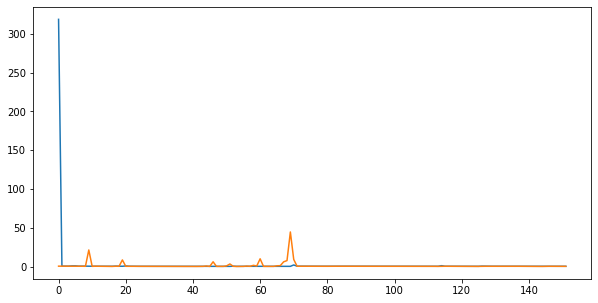

In [213]:
plt.figure(figsize=(10,5))
plt.plot(range(len(hist.history['loss'])), hist.history['loss'])
plt.plot(range(len(hist.history['val_loss'])), hist.history['val_loss'])
plt.show()

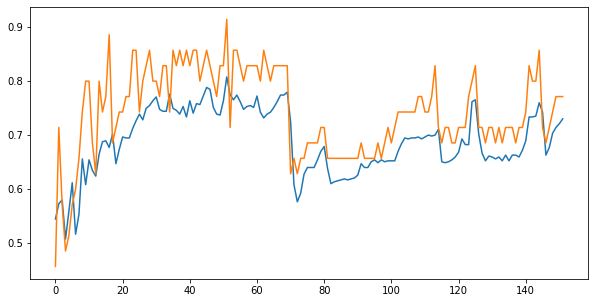

In [214]:
plt.figure(figsize=(10,5))
plt.plot(range(len(hist.history['acc'])), hist.history['acc'])
plt.plot(range(len(hist.history['val_acc'])), hist.history['val_acc'])
plt.show()

2022-08-03 18:51:05.653033: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


array([[1.7171584e-05]], dtype=float32)

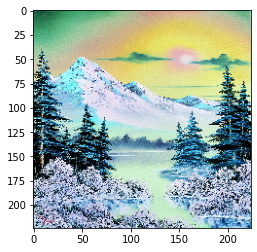

In [206]:
from keras.preprocessing import image
import matplotlib.pyplot as plt

img = image.load_img("./data/bob ross paintings/bob-ross-oak_on-a-clear-day-superJumbo.webp",target_size=(224,224))
img = np.asarray(img)
plt.imshow(img)
img = np.expand_dims(img, axis=0)

model_simple.predict(img)


array([[0.02475568]], dtype=float32)

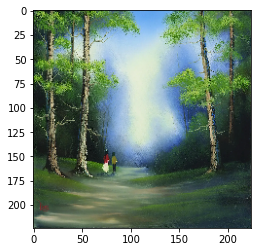

In [207]:

from keras.preprocessing import image
import matplotlib.pyplot as plt

img = image.load_img("./data/bob ross paintings/bob-ross-oak_morning-walk-superJumbo.webp",target_size=(224,224))
img = np.asarray(img)
plt.imshow(img)
img = np.expand_dims(img, axis=0)

model_simple.predict(img)


array([[1.]], dtype=float32)

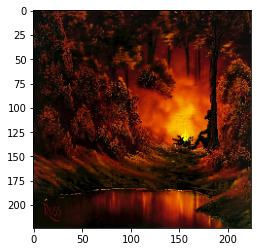

In [208]:
from keras.preprocessing import image
import matplotlib.pyplot as plt

img = image.load_img("./data/bob ross paintings/bob-ross-oak_campfire-superJumbo.webp",target_size=(224,224))
img = np.asarray(img)
plt.imshow(img)
img = np.expand_dims(img, axis=0)

model_simple.predict(img)